# 08 - Fault Proximity Analysis

This notebook analyzes the relationship between earthquake characteristics and distance to active fault lines.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os, sys, warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))
from config import *
from visualization import setup_style, create_turkey_basemap
from geo_utils import haversine_distance
setup_style()

OUTPUT_DIR = os.path.join(FIGURES_PATH, '08_fault')
os.makedirs(OUTPUT_DIR, exist_ok=True)

eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')
fault_df = pd.read_csv(FAULT_DATA)

# Filter records with fault distance data
eq_fault = eq_df[eq_df['fault_distance_km'].notna()].copy()

print(f"Records with fault distance data: {len(eq_fault):,}")

Records with fault distance data: 4,103


In [2]:
# Fault distance statistics
print("Fault Distance Statistics (M >= 4.0):")
print(f"  Mean: {eq_fault['fault_distance_km'].mean():.1f} km")
print(f"  Median: {eq_fault['fault_distance_km'].median():.1f} km")
print(f"  Std: {eq_fault['fault_distance_km'].std():.1f} km")
print(f"  Max: {eq_fault['fault_distance_km'].max():.1f} km")

# Percentage within certain distances
for dist in [10, 25, 50, 100]:
    pct = (eq_fault['fault_distance_km'] <= dist).mean() * 100
    print(f"  Within {dist} km: {pct:.1f}%")

Fault Distance Statistics (M >= 4.0):
  Mean: 96.3 km
  Median: 70.9 km
  Std: 74.9 km
  Max: 449.7 km
  Within 10 km: 1.3%
  Within 25 km: 7.7%
  Within 50 km: 32.4%
  Within 100 km: 65.4%


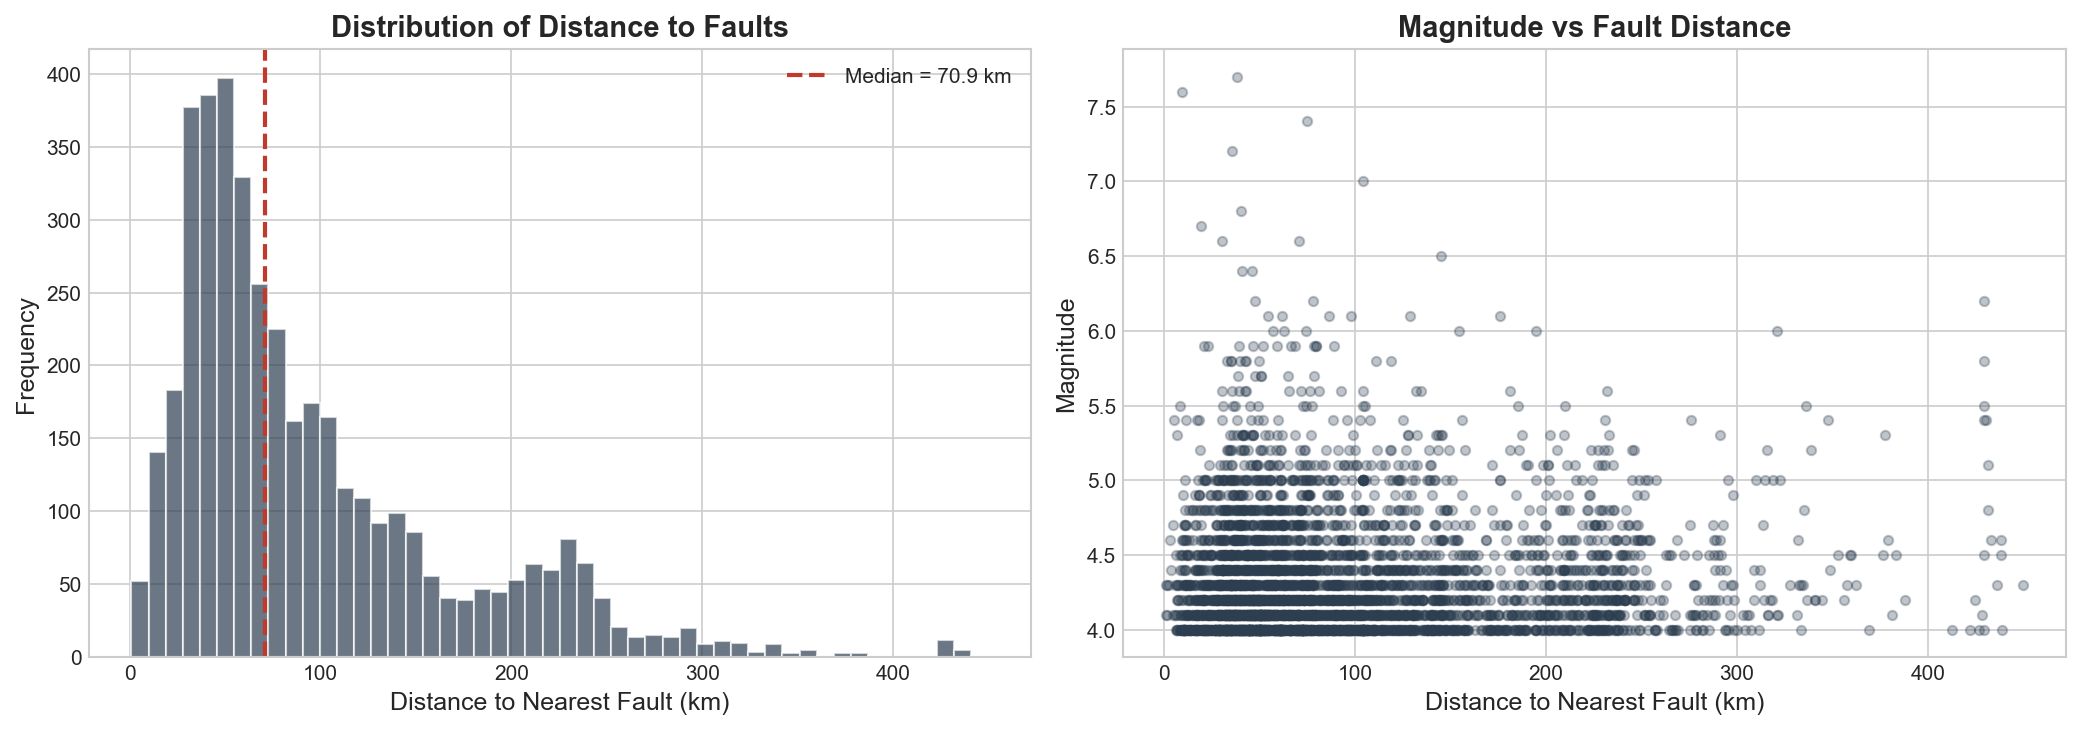

In [3]:
# Distance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(eq_fault['fault_distance_km'], bins=50, color=COLORS['primary'], 
         alpha=0.7, edgecolor='white')
ax1.axvline(eq_fault['fault_distance_km'].median(), color=COLORS['danger'], 
            linestyle='--', linewidth=2, label=f'Median = {eq_fault["fault_distance_km"].median():.1f} km')
ax1.set_xlabel('Distance to Nearest Fault (km)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Distance to Faults', fontweight='bold')
ax1.legend()

ax2 = axes[1]
ax2.scatter(eq_fault['fault_distance_km'], eq_fault['magnitude'], 
            alpha=0.3, s=20, c=COLORS['primary'])
ax2.set_xlabel('Distance to Nearest Fault (km)')
ax2.set_ylabel('Magnitude')
ax2.set_title('Magnitude vs Fault Distance', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'fault_distance_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

In [4]:
# Correlation analysis
r, p = stats.pearsonr(eq_fault['fault_distance_km'], eq_fault['magnitude'])
print(f"\nCorrelation (Distance vs Magnitude):")
print(f"  Pearson r = {r:.4f}")
print(f"  p-value = {p:.4e}")

# Spearman correlation
rho, p_spear = stats.spearmanr(eq_fault['fault_distance_km'], eq_fault['magnitude'])
print(f"\n  Spearman ρ = {rho:.4f}")
print(f"  p-value = {p_spear:.4e}")


Correlation (Distance vs Magnitude):
  Pearson r = 0.0197
  p-value = 2.0760e-01

  Spearman ρ = 0.0143
  p-value = 3.5859e-01


In [5]:
# Distance bins analysis
eq_fault['distance_bin'] = pd.cut(eq_fault['fault_distance_km'], 
                                   bins=[0, 10, 25, 50, 100, 500],
                                   labels=['0-10 km', '10-25 km', '25-50 km', '50-100 km', '>100 km'])

distance_stats = eq_fault.groupby('distance_bin', observed=True).agg({
    'eventID': 'count',
    'magnitude': ['mean', 'max'],
    'depth': 'mean'
}).round(2)
distance_stats.columns = ['count', 'mag_mean', 'mag_max', 'depth_mean']

print("\nStatistics by Distance Bin:")
distance_stats


Statistics by Distance Bin:


,count,mag_mean,mag_max,depth_mean
distance_bin,,,,
0-10 km,52,4.36,7.6,9.29
10-25 km,263,4.31,6.7,11.29
25-50 km,1014,4.36,7.7,10.71
50-100 km,1354,4.33,7.4,11.35
>100 km,1420,4.34,7.0,16.33


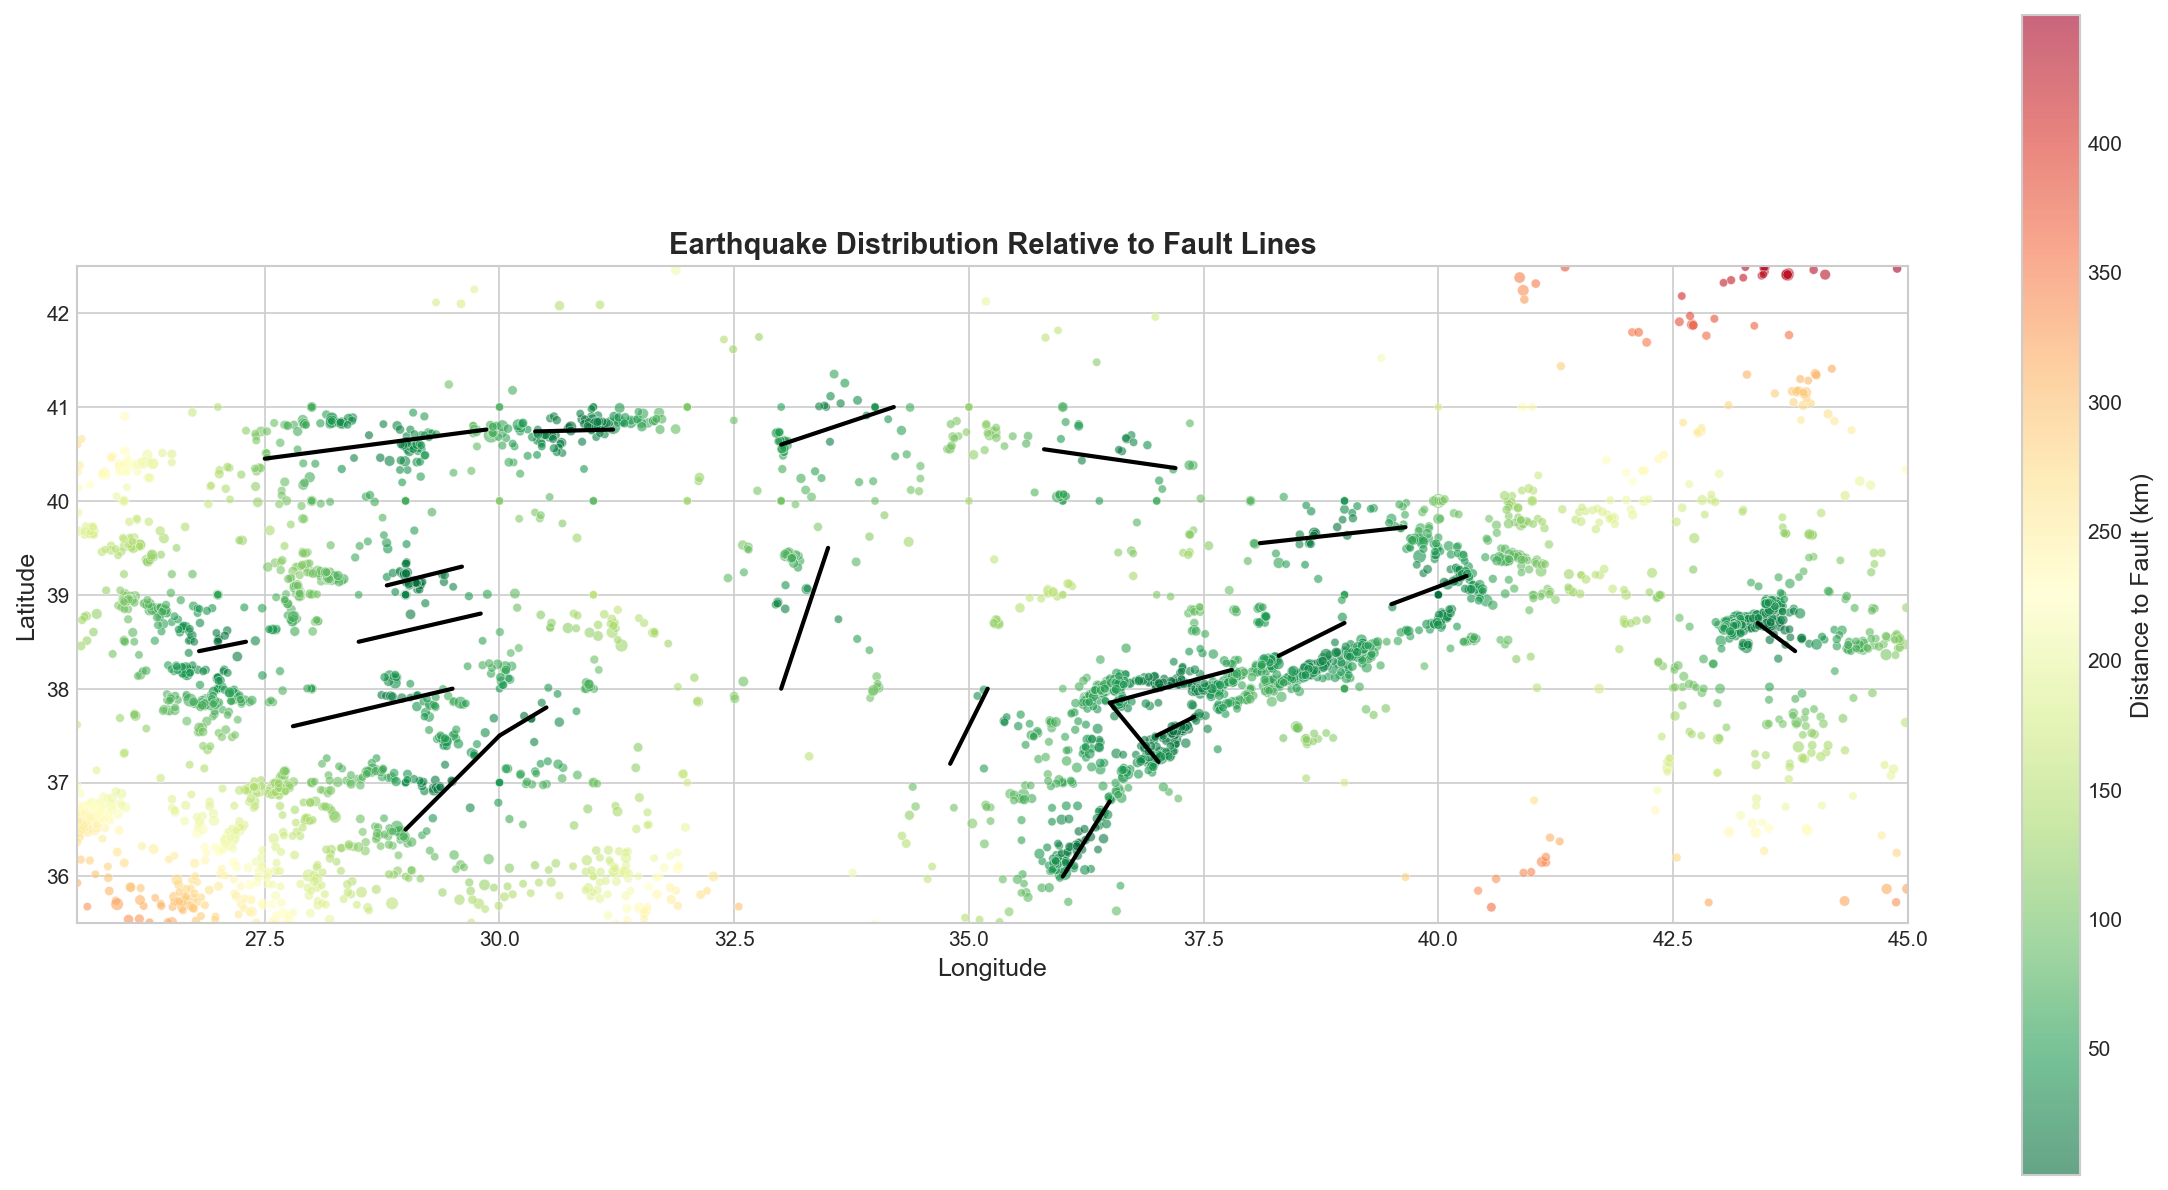

In [6]:
# Map with fault lines and earthquakes
fig, ax = plt.subplots(figsize=(16, 10))
ax = create_turkey_basemap(ax, 'Earthquake Distribution Relative to Fault Lines')

# Plot fault lines
for idx, fault in fault_df.iterrows():
    ax.plot([fault['lon_start'], fault['lon_end']], [fault['lat_start'], fault['lat_end']],
            color='black', linewidth=2, zorder=5)

# Plot earthquakes colored by distance
scatter = ax.scatter(eq_fault['longitude'], eq_fault['latitude'],
                     c=eq_fault['fault_distance_km'], s=eq_fault['magnitude']**2,
                     cmap='RdYlGn_r', alpha=0.6, edgecolors='white', linewidth=0.3)
plt.colorbar(scatter, ax=ax, label='Distance to Fault (km)', shrink=0.8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'earthquakes_fault_map.png'), dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Save results
distance_stats.to_csv(os.path.join(TABLES_PATH, 'fault_distance_analysis.csv'))
print(f"Results saved to: {os.path.join(TABLES_PATH, 'fault_distance_analysis.csv')}")

Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/fault_distance_analysis.csv
